In [87]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter
import cv2 as cv
from sklearn.preprocessing import minmax_scale
import emd
import os

SIGNAL_SAMPLING = 44_500
plt.style.use('./style.mplstyle')

In [88]:
def load_audio_data(path):
    y, _ = librosa.load(path, sr=SIGNAL_SAMPLING)
    print("audio data loaded, len: ", len(y))
    return y

def load_video_data(path) -> tuple[float, np.ndarray]:
    frames = []
    cap = cv.VideoCapture(path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    fps = cap.get(cv.CAP_PROP_FPS)
    return fps, np.array(frames)

def filter_audio(signal, low, high, fs, order=5):
    b, a = butter(order, [low, high], btype="band")
    return lfilter(b, a, signal)


def plot_audio(signal, sampling):
    librosa.display.waveshow(signal, sr=sampling)
    plt.show()
    
def save_audio_plot(signal):
    if not os.path.exists('./audio_results'):
        os.mkdir('./audio_results')
    plt.figure()
    plt.plot(signal)
    plt.savefig('./audio_results/audio')


def save_imfs_to_files(imfs):
    if not os.path.exists('./imf_results'):
        os.mkdir('./imf_results')
    for imf_index in range(imfs.shape[1]):
        imf = imfs[:, imf_index]
        plt.figure()
        plt.plot(imf[:])
        plt.savefig(f"imf_results/imf_{imf_index}")
        plt.close()

def calculate_imfs(signal):
    return emd.sift.sift(signal)

In [89]:
audio = load_audio_data(
    "../data/audio(wideo)/non_animal/D_non-contrast_1/D_non-contrast_1/REC70.WAV"
)

audio data loaded, len:  356352


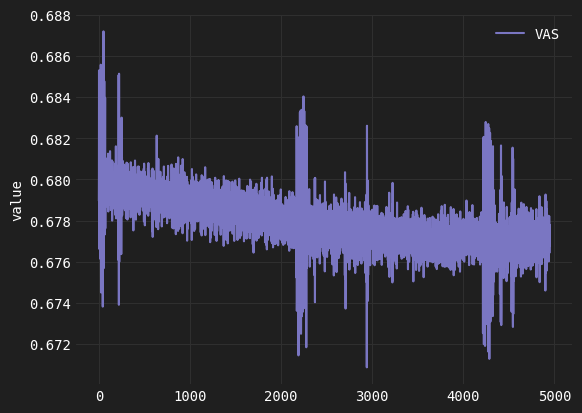

In [90]:
plt.plot(audio[50:5000], label='VAS')
plt.ylabel('value')
plt.legend()
plt.show()


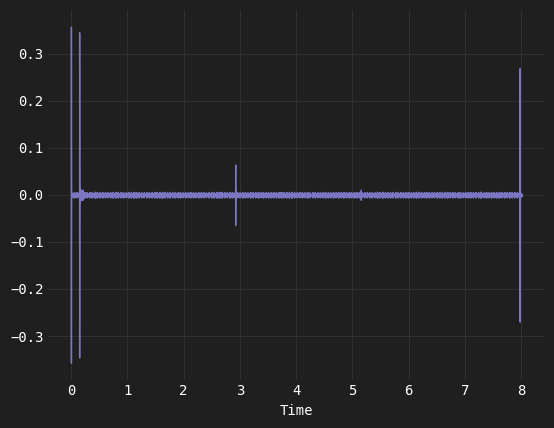

In [91]:
filtered_audio = filter_audio(audio, low=0.05, high=0.5, fs=SIGNAL_SAMPLING)
plot_audio(filtered_audio, sampling=SIGNAL_SAMPLING)

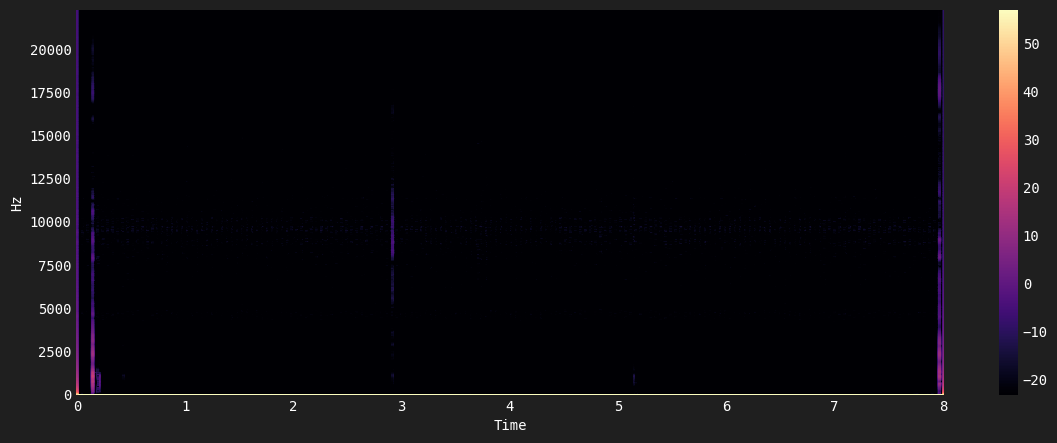

In [92]:
X = librosa.stft(audio)
X_db = librosa.amplitude_to_db(abs(X))
fig = plt.figure(figsize=(14, 5))
img = librosa.display.specshow(X_db, sr=SIGNAL_SAMPLING, x_axis='time', y_axis='hz')
fig.colorbar(img)

In [93]:
# TODO: add spectral centroid as a feature to nn
spectral_centroids = librosa.feature.spectral_centroid(y=audio[:1024], sr=SIGNAL_SAMPLING, n_fft=1024)[0]
centroid_frames = range(len(spectral_centroids))
centroid_times = librosa.frames_to_time(centroid_frames, sr=SIGNAL_SAMPLING)
centroid_times.shape, centroid_times[-1] # 

((3,), 0.02301123595505618)

In [94]:
spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=SIGNAL_SAMPLING)[0]
centroid_frames = range(len(spectral_centroids))
centroid_times = librosa.frames_to_time(centroid_frames, sr=SIGNAL_SAMPLING)
centroid_times.shape, centroid_times[-1] # 

((697,), 8.00791011235955)

In [95]:
spectral_centroids.shape

(697,)

In [96]:
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

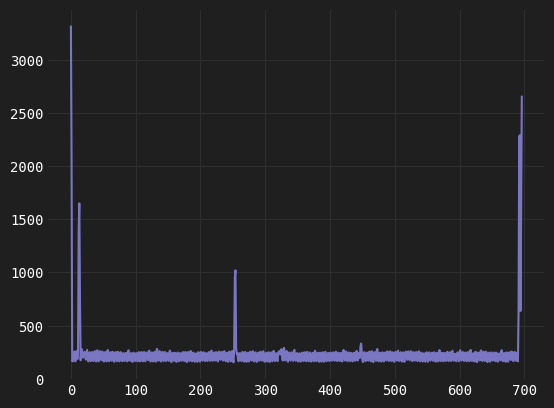

In [97]:
plt.figure()
plt.plot(spectral_centroids)
plt.show()

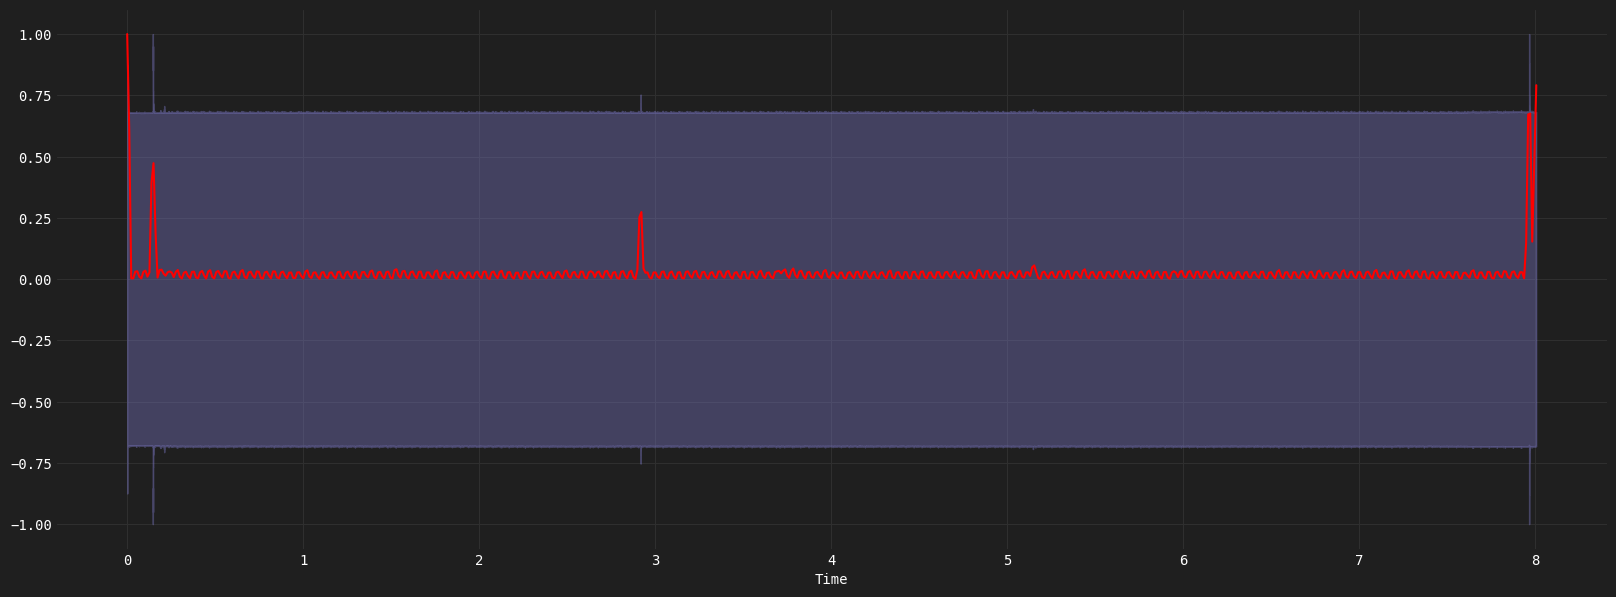

In [98]:
plt.figure(figsize=(20,7))
librosa.display.waveshow(audio, sr=SIGNAL_SAMPLING, alpha=0.4)
plt.plot(centroid_times, normalize(spectral_centroids), color='r')

(20, 5)


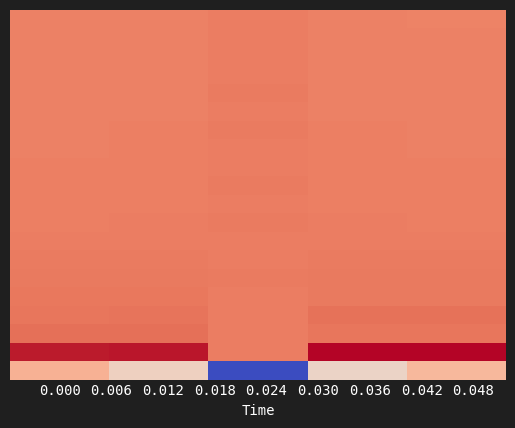

In [99]:
# TODO: add mfccs as feature to nn
mfccs = librosa.feature.mfcc(y=audio[:2048], sr=SIGNAL_SAMPLING)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=SIGNAL_SAMPLING, x_axis='time')

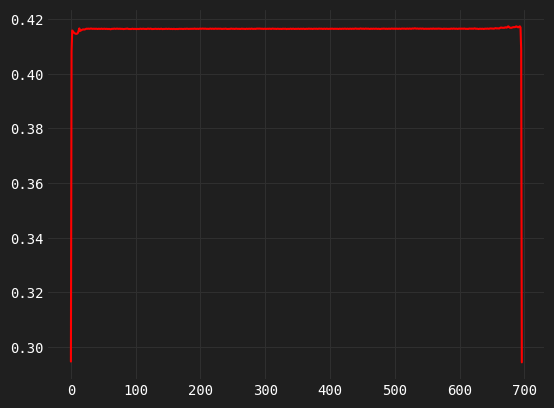

In [100]:
# Get RMS value from each frame's magnitude value
S, phase = librosa.magphase(librosa.stft(audio))
rms = librosa.feature.rms(S=S)
rms.shape
# Plot the RMS energy - it shows 
plt.plot(rms[0], color='r')
# It looks like there is no useful information in the RMS

In [101]:
pitches, magnitudes = librosa.piptrack(y=audio, sr=SIGNAL_SAMPLING)
print(np.all(pitches == 0))
print(np.all(magnitudes == 0))

True
True


In [102]:

# TODO: 4th file looks like an approximation of a base signal - shape is preserved and there aren't tons of details
# it could be used instead of an original signal in the input to nn
part = 10
imfs = calculate_imfs(audio[2048 * part: 2048 * (part + 1)])
print(imfs.shape)
# save_imfs_to_files(imfs)

(2048, 8)
